In [1]:
from Trainmodel import traindcnncoxmodel,traincnncoxmodel
from utils import avgcindex

2024-04-11 14:19:12.902137: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 
import numpy as np
import pandas as pd
#from model import cnncox,dcnncox,nncox
from earlystoping import MyCallback
from utils import nll,avgcindex,setup_seed
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold,train_test_split
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense,Dropout,Input,Flatten,concatenate
from tensorflow.keras.regularizers import l2

In [3]:

conv1_size=(1, 10)
conv2_size=(10, 1)
input_shape = (10, 10, 1)
le, wi = 10,10


seed=42

cancer_name='LGG'
Cindex=[]

current_path='../data/100'
output_path=current_path+'/' + cancer_name + "100.csv"
save_path="../save model/100/my2DCNNCox/"
os.makedirs(save_path,exist_ok=True)





setup_seed(seed)

df_exp=pd.read_csv(output_path,index_col=0)
gene_exp=df_exp.dropna(axis=0,subset = ["OS", "OS.time"])
E=np.array(gene_exp["OS"])
Y=np.array(gene_exp["OS.time"])

In [4]:
E.shape

(514,)

In [5]:
E[0:15]

array([1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])

In [6]:
Y.shape

(514,)

In [7]:
Y[0:15]

array([ 709.,  523.,  112., 1762., 2918.,  532.,   76.,  368.,  372.,
        758.,  623., 2381.,  204.,  354., 1354.])

In [8]:
X=np.array(gene_exp)

In [9]:
X.shape

(514, 102)

In [10]:
X[0:5,0:5]

array([[1.0000e+00, 7.0900e+02, 4.4496e+00, 4.0985e+00, 2.0183e+00],
       [0.0000e+00, 5.2300e+02, 5.5895e+00, 3.5473e+00, 1.6785e+00],
       [0.0000e+00, 1.1200e+02, 5.9074e+00, 3.3435e+00, 3.0270e+00],
       [1.0000e+00, 1.7620e+03, 4.2593e+00, 2.9032e+00, 6.8800e-01],
       [0.0000e+00, 2.9180e+03, 5.9014e+00, 3.6417e+00, 3.1955e+00]])

In [11]:
X=X.astype('float64')

In [12]:
X.shape

(514, 102)

In [13]:
X[0:5,0:5]

array([[1.0000e+00, 7.0900e+02, 4.4496e+00, 4.0985e+00, 2.0183e+00],
       [0.0000e+00, 5.2300e+02, 5.5895e+00, 3.5473e+00, 1.6785e+00],
       [0.0000e+00, 1.1200e+02, 5.9074e+00, 3.3435e+00, 3.0270e+00],
       [1.0000e+00, 1.7620e+03, 4.2593e+00, 2.9032e+00, 6.8800e-01],
       [0.0000e+00, 2.9180e+03, 5.9014e+00, 3.6417e+00, 3.1955e+00]])

In [14]:
# Remove the first two columns (OS and OS.time)
X=X[:,2:]

In [15]:
X.shape

(514, 100)

In [16]:
X[0:5,0:5]

array([[4.4496, 4.0985, 2.0183, 1.0642, 2.874 ],
       [5.5895, 3.5473, 1.6785, 1.7532, 1.9564],
       [5.9074, 3.3435, 3.027 , 2.4359, 3.97  ],
       [4.2593, 2.9032, 0.688 , 1.4065, 1.0503],
       [5.9014, 3.6417, 3.1955, 4.6949, 1.5316]])

In [17]:
scaler=StandardScaler().fit(X)

In [18]:
X[0:5,0:5]

array([[4.4496, 4.0985, 2.0183, 1.0642, 2.874 ],
       [5.5895, 3.5473, 1.6785, 1.7532, 1.9564],
       [5.9074, 3.3435, 3.027 , 2.4359, 3.97  ],
       [4.2593, 2.9032, 0.688 , 1.4065, 1.0503],
       [5.9014, 3.6417, 3.1955, 4.6949, 1.5316]])

In [19]:
X=scaler.transform(X)

In [20]:
X[0:5,0:5]

array([[-0.54960966,  0.29284883, -0.51964768, -0.45117084,  1.20086852],
       [ 0.6521546 , -0.21538826, -0.78101813, -0.07715054,  0.62943384],
       [ 0.98730756, -0.40330321,  0.25623334,  0.29344983,  1.88340167],
       [-0.75023755, -0.80928433, -1.5428999 , -0.26535495,  0.06516077],
       [ 0.98098193, -0.12834621,  0.3858417 ,  1.519737  ,  0.36488997]])

In [21]:
X.shape

(514, 100)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 10, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 10, 1, 128)           1408      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 1, 10, 8)             88        ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 5, 1, 128)            0         ['conv2d[0][0]']              
 D)                                                                                           

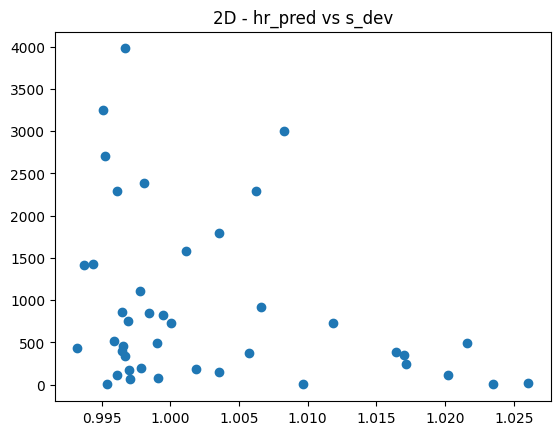

[[1.0015432 ]
 [0.9957901 ]
 [0.9955239 ]
 [0.9958593 ]
 [0.99251413]
 [0.99528   ]
 [0.99828327]
 [0.995303  ]
 [0.99736154]
 [1.0101441 ]
 [0.9950434 ]
 [0.9950639 ]
 [0.99822474]
 [1.000637  ]
 [0.99978876]
 [0.9965587 ]
 [0.99510455]
 [0.99713963]
 [0.9960402 ]
 [0.9967378 ]
 [1.0014048 ]
 [0.99397457]
 [0.9994365 ]
 [1.0122769 ]
 [0.9941423 ]
 [0.99760336]
 [1.0149465 ]
 [0.99797535]
 [1.0061679 ]
 [0.99685377]
 [0.9944633 ]
 [1.008365  ]
 [0.9972285 ]
 [0.997027  ]
 [0.99671817]
 [0.99739176]
 [0.997472  ]
 [0.9973498 ]
 [0.994789  ]
 [0.9983266 ]
 [1.0131829 ]
 [0.99618906]
 [0.994815  ]
 [0.994872  ]
 [1.0008351 ]
 [1.0200434 ]
 [0.9939693 ]
 [1.0104325 ]
 [1.0035979 ]
 [1.0019803 ]
 [0.9966983 ]
 [0.99577975]
 [1.0104544 ]
 [1.0054104 ]
 [0.99601007]
 [1.0248646 ]
 [1.0276161 ]
 [0.997746  ]
 [0.9991911 ]
 [0.9973056 ]
 [0.996049  ]
 [1.0194364 ]
 [0.99527526]
 [0.99845   ]
 [0.9967571 ]
 [1.0128096 ]
 [0.9959641 ]
 [0.99575216]
 [1.0242866 ]
 [0.99644375]
 [1.019506  ]
 [0.99

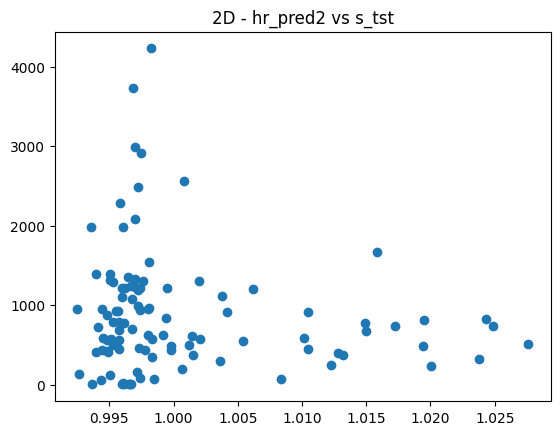

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 10, 10, 1)]          0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 10, 1, 128)           1408      ['input_2[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 1, 10, 8)             88        ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 5, 1, 128)            0         ['conv2d_2[0][0]']            
 g2D)                                                                                       

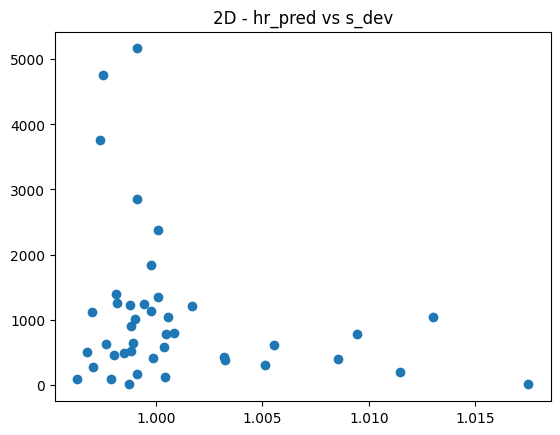

[[0.99667495]
 [1.0054584 ]
 [1.0006503 ]
 [1.0005132 ]
 [1.0117731 ]
 [0.99531657]
 [0.99781287]
 [1.0043329 ]
 [1.0168602 ]
 [0.9980414 ]
 [0.99982095]
 [1.0008682 ]
 [0.99927896]
 [0.9986672 ]
 [0.9998753 ]
 [1.0076126 ]
 [1.0105293 ]
 [0.99949574]
 [1.0083174 ]
 [0.9991562 ]
 [1.010436  ]
 [1.0043483 ]
 [1.0122238 ]
 [0.9995884 ]
 [0.9992582 ]
 [0.998203  ]
 [0.99903506]
 [1.0004095 ]
 [1.0001838 ]
 [1.0104746 ]
 [0.99991095]
 [1.0022916 ]
 [1.0006397 ]
 [1.0122924 ]
 [1.0024598 ]
 [1.0025347 ]
 [1.0084788 ]
 [0.9984303 ]
 [0.9979028 ]
 [1.0007796 ]
 [1.0070081 ]
 [1.000317  ]
 [1.0140202 ]
 [1.0184983 ]
 [0.99686277]
 [1.0129528 ]
 [0.9984881 ]
 [0.9995388 ]
 [1.0001076 ]
 [1.0153382 ]
 [0.9946728 ]
 [0.9993078 ]
 [0.99943286]
 [0.9977811 ]
 [1.0130354 ]
 [1.0019484 ]
 [1.0092562 ]
 [1.0000205 ]
 [0.99787784]
 [0.99939173]
 [1.0065504 ]
 [0.9997096 ]
 [1.0034348 ]
 [0.9996102 ]
 [1.0068848 ]
 [0.9995662 ]
 [1.0114318 ]
 [0.9992079 ]
 [0.99921066]
 [1.0111238 ]
 [0.99990535]
 [1.00

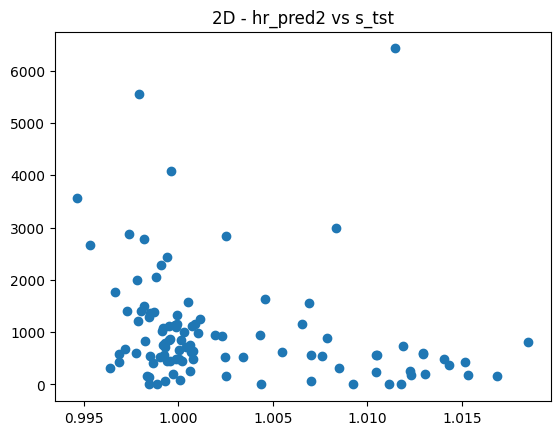

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 10, 10, 1)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 10, 1, 128)           1408      ['input_3[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 1, 10, 8)             88        ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 5, 1, 128)            0         ['conv2d_4[0][0]']            
 g2D)                                                                                       

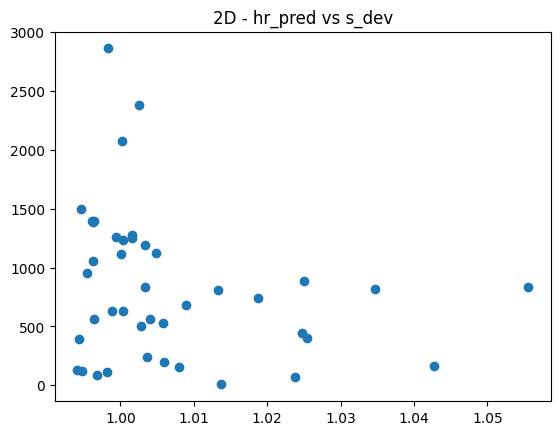

[[0.99872905]
 [1.0402198 ]
 [0.99888104]
 [1.0501051 ]
 [0.9971155 ]
 [1.0384121 ]
 [1.0081517 ]
 [1.0005293 ]
 [1.0337445 ]
 [1.0174617 ]
 [1.0015616 ]
 [1.0000772 ]
 [1.0018204 ]
 [0.9968022 ]
 [0.9988232 ]
 [0.9948918 ]
 [1.0100543 ]
 [0.9937211 ]
 [1.0013497 ]
 [0.9976835 ]
 [1.0057209 ]
 [0.9969383 ]
 [0.995205  ]
 [1.0391003 ]
 [1.0027887 ]
 [1.0431253 ]
 [1.0262697 ]
 [0.99657226]
 [0.99656934]
 [1.0408602 ]
 [1.0373715 ]
 [1.0353099 ]
 [1.0166678 ]
 [0.9993707 ]
 [1.0125362 ]
 [0.99793386]
 [0.99960625]
 [1.0435534 ]
 [0.99994016]
 [0.99575007]
 [1.0296274 ]
 [0.99916667]
 [0.99753356]
 [0.99927473]
 [1.0025082 ]
 [1.0422664 ]
 [0.9987397 ]
 [0.9979544 ]
 [0.99746436]
 [1.0037811 ]
 [1.0370148 ]
 [0.9933197 ]
 [0.9918641 ]
 [1.0137376 ]
 [1.0029346 ]
 [0.9938695 ]
 [1.0055463 ]
 [0.9995803 ]
 [1.0093204 ]
 [1.0014385 ]
 [1.0031748 ]
 [0.99945503]
 [1.051206  ]
 [0.99686676]
 [1.0015743 ]
 [1.0051973 ]
 [0.9994343 ]
 [0.9978989 ]
 [1.0037543 ]
 [1.0324382 ]
 [1.0508155 ]
 [0.99

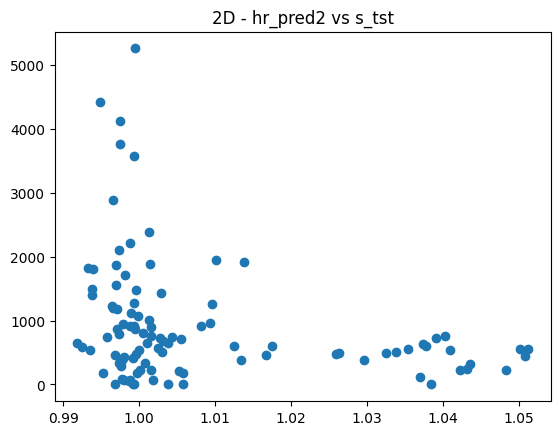

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 10, 10, 1)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 10, 1, 128)           1408      ['input_4[0][0]']             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 1, 10, 8)             88        ['input_4[0][0]']             
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 5, 1, 128)            0         ['conv2d_6[0][0]']            
 g2D)                                                                                       

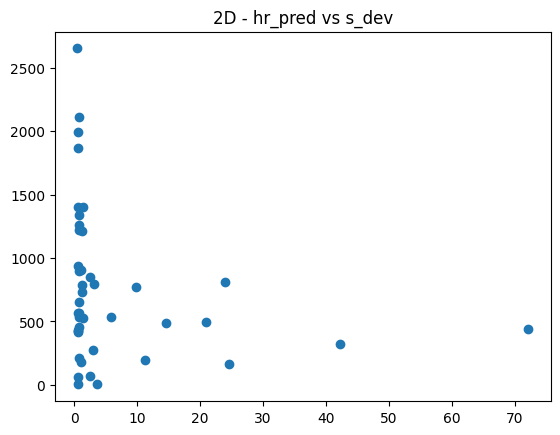

[[ 0.6300992 ]
 [ 0.74508876]
 [ 0.62576205]
 [ 0.5358426 ]
 [14.804414  ]
 [ 0.7495919 ]
 [ 0.63606167]
 [ 0.5482665 ]
 [ 0.69434625]
 [ 0.60180885]
 [ 0.55811924]
 [53.319794  ]
 [ 2.1755636 ]
 [ 0.6736473 ]
 [ 0.80237734]
 [ 0.6206872 ]
 [ 0.72710323]
 [ 2.8697588 ]
 [ 0.6453961 ]
 [ 0.6482646 ]
 [ 1.4598944 ]
 [ 0.86788064]
 [ 1.1371591 ]
 [ 0.573982  ]
 [ 0.69164675]
 [ 1.0558431 ]
 [ 0.79830253]
 [ 0.8769585 ]
 [ 0.66580343]
 [ 5.420466  ]
 [21.900406  ]
 [ 0.8231937 ]
 [ 0.5904414 ]
 [ 0.6250864 ]
 [ 0.6611278 ]
 [13.071491  ]
 [ 0.7456816 ]
 [ 0.59935236]
 [ 0.59355015]
 [ 0.72021264]
 [24.584677  ]
 [13.253427  ]
 [ 0.91525364]
 [ 0.6409102 ]
 [ 0.5593683 ]
 [45.40694   ]
 [ 6.609876  ]
 [ 0.7152814 ]
 [ 1.650141  ]
 [ 4.163344  ]
 [20.693008  ]
 [ 2.633896  ]
 [ 0.7590704 ]
 [ 1.3302426 ]
 [ 0.5866767 ]
 [ 0.7301821 ]
 [ 0.895414  ]
 [ 0.66760457]
 [ 1.0877357 ]
 [ 0.7402554 ]
 [ 0.74070966]
 [ 0.79405296]
 [ 1.0702535 ]
 [ 1.7113047 ]
 [ 7.4071054 ]
 [ 4.7275996 ]
 [ 0.61033

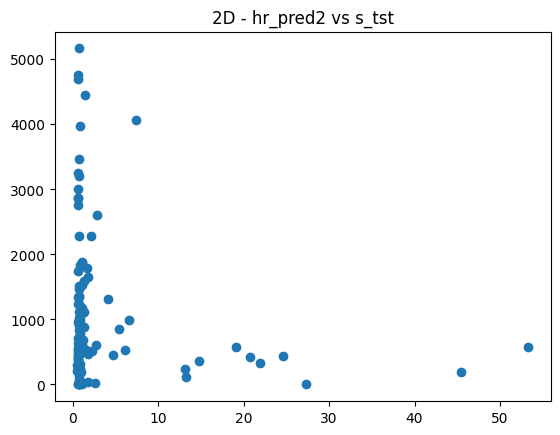

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 10, 10, 1)]          0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 10, 1, 128)           1408      ['input_5[0][0]']             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 1, 10, 8)             88        ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 5, 1, 128)            0         ['conv2d_8[0][0]']            
 g2D)                                                                                       

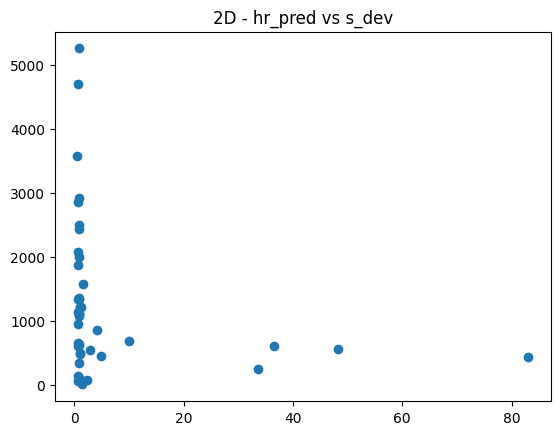

[[ 1.4635112 ]
 [ 0.8435397 ]
 [ 0.7903136 ]
 [ 1.0516828 ]
 [ 0.77077115]
 [ 0.71439403]
 [13.508034  ]
 [57.55111   ]
 [13.885102  ]
 [40.37416   ]
 [ 0.73932844]
 [ 1.2444017 ]
 [ 0.7377288 ]
 [ 1.3235786 ]
 [ 0.6464856 ]
 [ 4.385981  ]
 [ 0.8288037 ]
 [ 0.6777603 ]
 [ 6.2242594 ]
 [ 2.6647189 ]
 [ 1.0549669 ]
 [34.25238   ]
 [ 2.7241335 ]
 [ 0.6680085 ]
 [43.45186   ]
 [ 0.69918144]
 [ 3.354274  ]
 [46.729908  ]
 [ 0.9721161 ]
 [10.106783  ]
 [ 0.6256294 ]
 [ 0.73075104]
 [ 0.72304887]
 [ 1.3799739 ]
 [ 1.0623704 ]
 [ 0.78316206]
 [ 0.65600747]
 [ 1.0911072 ]
 [ 0.7030371 ]
 [ 0.7271345 ]
 [ 0.6433036 ]
 [ 0.9509423 ]
 [ 0.76289016]
 [ 1.5064373 ]
 [ 0.7011864 ]
 [ 0.63907963]
 [ 0.82262176]
 [ 1.6074162 ]
 [ 0.63567483]
 [ 1.305826  ]
 [ 0.68735933]
 [ 0.75223595]
 [ 0.62607306]
 [35.68606   ]
 [ 0.7241304 ]
 [ 0.6363207 ]
 [ 0.71259403]
 [14.173717  ]
 [ 1.2573303 ]
 [ 0.8788388 ]
 [ 0.7539611 ]
 [10.473863  ]
 [ 1.5099467 ]
 [ 0.6475678 ]
 [ 0.7478341 ]
 [ 1.0997353 ]
 [ 0.65055

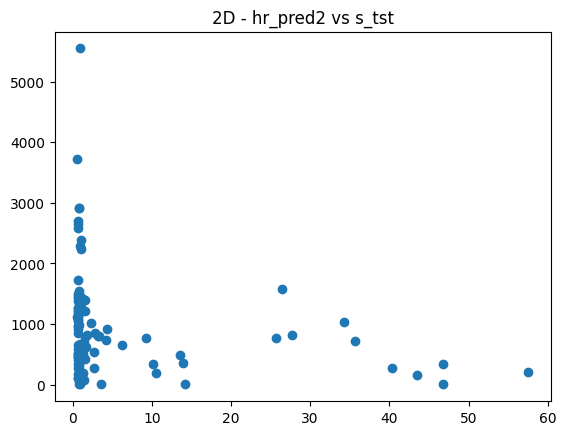

In [22]:
score_tst_list = []
score_dev_list = []

le, wi = 10,10
conv1_size=(1, le)
conv2_size=(wi, 1)
input_shape = (le, wi, 1)

# using just 1 loop for now
for i in range(0,1):
        ci_tst_list = []
        ci_dev_list = []
        kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
        fold = 0
        for trn_index, tst_index in kf.split(X,E):
            fold +=1
            x_tst=X[tst_index]
            c_tst=E[tst_index]
            s_tst=Y[tst_index]

            x_trn, x_dev ,c_trn, c_dev , s_trn, s_dev=train_test_split(
                X[trn_index],E[trn_index],Y[trn_index],test_size=0.1,
                stratify=E[trn_index],random_state=1)

            sort_idx = np.argsort(s_trn)[::-1]
            x_trn = x_trn[sort_idx]
            s_trn = s_trn[sort_idx]
            c_trn = c_trn[sort_idx]

            x_trn = np.reshape(x_trn, (-1, le, wi))
            x_dev = np.reshape(x_dev, (-1, le, wi))
            x_tst = np.reshape(x_tst, (-1, le, wi))

            x_trn = x_trn.reshape(x_trn.shape[0], le, wi, 1)
            x_dev = x_dev.reshape(x_dev.shape[0], le, wi, 1)
            x_tst = x_tst.reshape(x_tst.shape[0], le, wi, 1)
        
            #fit
            data = (x_trn, c_trn, s_trn, x_dev, c_dev, s_dev)
            modelpath = save_path+"%s_fold_%s_repeat_%s_%s.hdf5" % (
                cancer_name,fold,i+1,le*wi)
            checkpoint = MyCallback(modelpath, data)
            
            
            

            
            
            conv1=128
            conv2=8
            dense=32
            input_img = Input(input_shape)
            tower_1 = Conv2D(conv1, conv1_size, activation='relu')(input_img)
            tower_1 = MaxPooling2D(1, 2)(tower_1)
            tower_1 = Flatten()(tower_1)
            tower_2 = Conv2D(conv2, conv2_size, activation='relu')(input_img)
            tower_2 = MaxPooling2D(1, 2)(tower_2)
            tower_2 = Flatten()(tower_2)
            output = concatenate([tower_1, tower_2], axis=1)
            out1 = Dense(dense, activation='relu')(output)
            last_layer = Dense(1, kernel_initializer='zeros', bias_initializer='zeros')(out1)
            model = Model(inputs=[input_img], outputs=last_layer)
            
            
            #conv1=128
            #dense=128
            #input_img = Input(input_shape)
            #tower = Conv2D(conv1, conv1_size, activation='relu')(input_img)
            #tower1 = MaxPooling2D(1, 2)(tower)
            #tower2 = Flatten()(tower1)
            #out = Dense(dense, activation='relu')(tower2)
            #last_layer = Dense(1, kernel_initializer='zeros', bias_initializer='zeros')(out)
            #model = Model(inputs=[input_img], outputs=last_layer)

            
            
            
            model.compile(loss=[nll(c_trn, np.sum(c_trn))],
                          optimizer="adam")
            print(model.summary())
            
            print('Training...')
            history = model.fit(x_trn, s_trn, batch_size=len(x_trn),
                                epochs=100,verbose=0,callbacks=[checkpoint], shuffle=False)
            model.load_weights(modelpath)
        
            hr_pred=model.predict(x_dev,batch_size=1, verbose=0)
            hr_pred=np.exp(hr_pred)
            print(hr_pred)
            fig,ax = plt.subplots(1)
            ax.scatter(hr_pred,s_dev)

            
            #log_pred = [-np.log(p) for p in hr_pred]
            #ax.scatter(hr_pred,log_pred)


            plt.title("2D - hr_pred vs s_dev")
            plt.show()
            ci_dev=concordance_index(s_dev,-hr_pred,c_dev)
            
            hr_pred2=model.predict(x_tst,batch_size=1, verbose=0)
            hr_pred2=np.exp(hr_pred2)
            print(hr_pred2)
            fig,ax = plt.subplots(1)
            ax.scatter(hr_pred2,s_tst)
            plt.title("2D - hr_pred2 vs s_tst")
            plt.show()
            ci_tst=concordance_index(s_tst,-hr_pred2,c_tst)
            
            ci_dev_list.append(ci_dev)
            ci_tst_list.append(ci_tst)
            
        score_dev_list.append(ci_dev_list)
        score_tst_list.append(ci_tst_list)


If the hazard ratio is less than 1, then the predictor is protective (i.e., associated with improved survival) and if the hazard ratio is greater than 1, then the predictor is associated with increased risk (or decreased survival).
